# PPO MARL agent using stable-baselines3

In this notebook, we will look at policy optimization using PPO for a multi-agent environment. 

The code below follows the tutorial [SB3: PPO for Knights-Archers-Zombies](https://pettingzoo.farama.org/tutorials/sb3/kaz/) that comes with the [PettingZoo](https://pettingzoo.farama.org/) library. 

#### Running in Colab/Kaggle

If you are running this on Colab, please uncomment below cell and run this to install required dependencies.

In [ ]:
## uncomment and execute this cell to install all the the dependencies if running in Google Colab or Kaggle
# !apt-get update 
# !apt-get install -y swig cmake ffmpeg freeglut3-dev xvfb

## Uncomment and execute this cell to install all the the dependencies if running in Google Colab or Kaggle

## Uncomment and run for Colab
# !git clone https://github.com/nsanghi/drl-2ed
# %cd drl-2ed 
# !pip install  -r requirements.txt
# %cd ..


In [ ]:
## Uncomment and Rerun the cd command in case you were asked to restart the kernel and you followed that message
## as after resart the kernel will again point back to root folder


## Uncomment and run for Colab
# %cd /content/drl-2ed 
# %cd chapter6


## Uncomment and run for Kaggle
# %cd /kaggle/working/drl-2ed 
# %cd chapter6

#### Imports

In [1]:
from __future__ import annotations

import glob
import os
import time

import supersuit as ss
from stable_baselines3 import PPO
from stable_baselines3.ppo import CnnPolicy, MlpPolicy

from pettingzoo.butterfly import knights_archers_zombies_v10

import random
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output, display

%matplotlib inline

2024-02-24 10:55:02.794429: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-24 10:55:02.796430: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-24 10:55:02.828036: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 10:55:02.828064: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 10:55:02.828081: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

### Environment - Knights Archers Zombies

Knights Archers Zombies is part of Butterfly environment. Butterfly environments are challenging scenarios created by Farama, using Pygame with visual Atari spaces. All environments require a high degree of coordination and require learning of emergent behaviors to achieve an optimal policy. As such, these environments are currently very challenging to learn. Environments are highly configurable via arguments specified in their respective documentation.

By default, PettingZoo models games as Agent Environment Cycle (AEC) environments. This allows PettingZoo to represent any type of game multi-agent RL can consider. In this model, agents sequentially see their observation,
agents take actions, rewards are emitted from the other agents, and the next agent to act is chosen 
This is effectively a sequentially stepping form of the POSG mode You can read more about it in [PettingZoo: A Standard API for Multi-Agent Reinforcement Learning](https://arxiv.org/pdf/2009.14471.pdf). Specifically refer to Appendix C3 for a detailed mathematical formulation of AEC

In Knights Archers Zombies, Zombies walk from the top border of the screen down to the bottom border in unpredictable paths. The agents you control are knights and archers (default 2 knights and 2 archers) that are initially positioned at the bottom border of the screen. Each agent can rotate clockwise or counter-clockwise and move forward or backward. Each agent can also attack to kill zombies. When a knight attacks, it swings a mace in an arc in front of its current heading direction. When an archer attacks, it fires an arrow in a straight line in the direction of the archer’s heading. The game ends when all agents die (collide with a zombie) or a zombie reaches the bottom screen border. A knight is rewarded 1 point when its mace hits and kills a zombie. An archer is rewarded 1 point when one of their arrows hits and kills a zombie. There are two possible observation types for this environment, vectorized and image-based. We will use vectorized space
|  |  |
|---|---|
| Agents | `agents= ['archer_0', 'archer_1', 'knight_0', 'knight_1']` |
| Agents | `4` |
| Action Shape | `(1,)` |
|Action Values |  `[0, 5]` 

Pass the argument `vector_state=True` to the environment to get a vectorized environment.

The observation is an `(N+1)x5` array for each agent, where `N = num_archers + num_knights + num_swords + max_arrows + max_zombies`. and the `1` refers to the current agent.

In total, there will be N+1 rows. Rows with no entities will be all 0, but the ordering of the entities will not change.

Vector Breakdown

This breaks down what a row in the observation means. All distances are normalized to `[0, 1]`. Note that for positions, `[0, 0]` is the top left corner of the image. Down is positive y, Left is positive x.

For the vector for current agent:

* The first value means nothing and will always be 0.
* The next four values are the position and angle of the current agent.
  * The first two values are position values, normalized to the width and height of the image respectively.
  * The final two values are heading of the agent represented as a unit vector.

For everything else:

* Each row of the matrix (this is an 5 wide vector) has a breakdown that looks something like this:
  * The first value is the absolute distance between an entity and the current agent.
  * The next four values are relative position and absolute angles of each entity relative to the current agent.
    * The first two values are position values relative to the current agent.
    * The final two values are the angle of the entity represented as a directional unit vlative to the world.


.


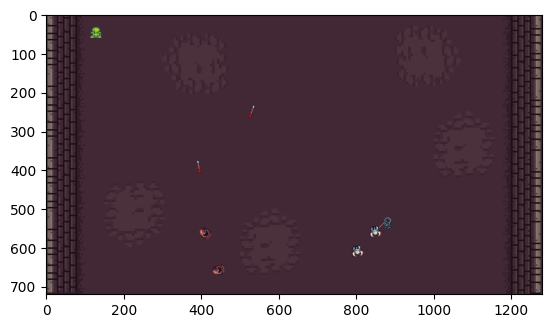

In [6]:
env = knights_archers_zombies_v10.env(render_mode="rgb_array")
env.reset(seed=42)

for agent in env.agent_iter(10):
    observation, reward, termination, truncation, info = env.last()

    if termination or truncation:
        action = None
    else:
        # this is where you would insert your policy
        action = env.action_space(agent).sample()

    env.step(action)
    plt.imshow(env.render())
    display(plt.gcf())
    clear_output(wait=True)

env.close()

## Train function

In [3]:
def train(env_fn, steps: int = 10_000, seed: int | None = 0, **env_kwargs):
    # Train a single model to play as each agent in an AEC environment
    env = env_fn.parallel_env(**env_kwargs)

    # Add black death wrapper so the number of agents stays constant
    # MarkovVectorEnv does not support environments with varying numbers of active agents unless black_death is set to True
    env = ss.black_death_v3(env)

    # Pre-process using SuperSuit
    visual_observation = not env.unwrapped.vector_state
    if visual_observation:
        # If the observation space is visual, reduce the color channels, resize from 512px to 84px, and apply frame stacking
        env = ss.color_reduction_v0(env, mode="B")
        env = ss.resize_v1(env, x_size=84, y_size=84)
        env = ss.frame_stack_v1(env, 3)

    env.reset(seed=seed)

    print(f"Starting training on {str(env.metadata['name'])}.")

    env = ss.pettingzoo_env_to_vec_env_v1(env)
    env = ss.concat_vec_envs_v1(env, 8, num_cpus=1, base_class="stable_baselines3")

    # Use a CNN policy if the observation space is visual
    model = PPO(
        CnnPolicy if visual_observation else MlpPolicy,
        env,
        verbose=3,
        batch_size=256,
    )

    model.learn(total_timesteps=steps)

    model.save(f"{env.unwrapped.metadata.get('name')}_{time.strftime('%Y%m%d-%H%M%S')}")

    print("Model has been saved.")

    print(f"Finished training on {str(env.unwrapped.metadata['name'])}.")

    env.close()

## Evaluate Function

In [4]:
def eval(env_fn, num_games: int = 100, render_mode: str | None = None, **env_kwargs):
    # Evaluate a trained agent vs a random agent
    env = env_fn.env(render_mode=render_mode, **env_kwargs)

    # Pre-process using SuperSuit
    visual_observation = not env.unwrapped.vector_state
    if visual_observation:
        # If the observation space is visual, reduce the color channels, resize from 512px to 84px, and apply frame stacking
        env = ss.color_reduction_v0(env, mode="B")
        env = ss.resize_v1(env, x_size=84, y_size=84)
        env = ss.frame_stack_v1(env, 3)

    print(
        f"\nStarting evaluation on {str(env.metadata['name'])} (num_games={num_games}, render_mode={render_mode})"
    )

    try:
        latest_policy = max(
            glob.glob(f"{env.metadata['name']}*.zip"), key=os.path.getctime
        )
    except ValueError:
        print("Policy not found.")
        exit(0)

    model = PPO.load(latest_policy)

    rewards = {agent: 0 for agent in env.possible_agents}

    # Note: we evaluate here using an AEC environments, to allow for easy A/B testing against random policies
    # For example, we can see here that using a random agent for archer_0 results in less points than the trained agent
    for i in range(num_games):
        env.reset(seed=i)
        env.action_space(env.possible_agents[0]).seed(i)

        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()

            for a in env.agents:
                rewards[a] += env.rewards[a]

            if termination or truncation:
                break
            else:
                if agent == env.possible_agents[0]:
                    act = env.action_space(agent).sample()
                else:
                    act = model.predict(obs, deterministic=True)[0]
            env.step(act)
    env.close()

    avg_reward = sum(rewards.values()) / len(rewards.values())
    avg_reward_per_agent = {
        agent: rewards[agent] / num_games for agent in env.possible_agents
    }
    print(f"Avg reward: {avg_reward}")
    print("Avg reward per agent, per game: ", avg_reward_per_agent)
    print("Full rewards: ", rewards)
    return avg_reward

## Train and Evaluate the Agent

In [5]:
env_fn = knights_archers_zombies_v10

# Set vector_state to false in order to use visual observations (significantly longer training time)
env_kwargs = dict(max_cycles=100, max_zombies=4, vector_state=True)

# Train a model (takes ~5 minutes on a laptop CPU)
train(env_fn, steps=81_920, seed=0, **env_kwargs)

# Evaluate 10 games (takes ~10 seconds on a laptop CPU)
eval(env_fn, num_games=10, render_mode=None, **env_kwargs)

# Watch 2 games (takes ~10 seconds on a laptop CPU)
# Will not work on Google Colab
eval(env_fn, num_games=2, render_mode="human", **env_kwargs)

Starting training on knights_archers_zombies_v10.
Using cpu device
------------------------------
| time/              |       |
|    fps             | 1062  |
|    iterations      | 1     |
|    time_elapsed    | 61    |
|    total_timesteps | 65536 |
------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 925        |
|    iterations           | 2          |
|    time_elapsed         | 141        |
|    total_timesteps      | 131072     |
| train/                  |            |
|    approx_kl            | 0.00739076 |
|    clip_fraction        | 0.053      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.79      |
|    explained_variance   | 0.0429     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.00427    |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.00401   |
|    value_loss           | 0.0279     |
-------------------

0.25